In [94]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
from datetime import date
from datetime import timedelta
import time
%matplotlib inline
from pathlib import Path 
import os
from matplotlib.ticker import ScalarFormatter
from matplotlib import ticker

In [95]:
#Find yesterday's date and convert it to string
today=date.today()
yesterday=today-timedelta(days=1)
ydate=yesterday.strftime("%d-%m-%Y")
todate=today.strftime("%d-%m-%Y")

#Specify Data folder
data_folder = Path("../data")

#Compute filename
data_file = ydate + ".csv"

#Compute complete filepath for the day
file_path = data_folder / data_file

#Read file to data frame
df=pd.read_csv(file_path)

df['Date']= pd.to_datetime(df['Date'], dayfirst=True)
df=df[df['Date']!=today] #Drop today's data
df_h=df[df['Status']=='Hospitalized']
df_r=df[df['Status']=='Recovered']
df_d=df[df['Status']=='Deceased']

#Daily New Cases count in India
ind_daily=pd.DataFrame(df_h.groupby('Date')['Num_Cases'].sum())
ind_daily.rename(columns={'Num_Cases':'Daily New Cases'}, inplace=True)
#ind_daily.tail(10)

#Cumulative Cases in India
ind_cum=ind_daily.cumsum()
ind_cum.rename(columns={'Daily New Cases':'Cumulative Cases'},inplace=True)

#Specify Export folder 
export_folder =Path("../exports")
export_folder_path = export_folder / ydate

try:
    os.mkdir(export_folder_path)
    print('New Directory Created for today')
except:
    print("Directory already exists")

#File Name for States Daily and file path
fnsd = "State Daily.csv"
fpsd = export_folder_path / fnsd

#File Name for States Cumulative and filepath 
fnsc = "State Cumulative.csv"
fpsc = export_folder_path / fnsc

#Create a time series for States by New Cases
states=pd.DataFrame(df_h.groupby(['Date','State'])['Num_Cases'].sum())
states.rename(columns={'Num_Cases':'Daily New Cases'}, inplace=True)
state_daily=states.pivot_table(index='Date', columns='State', fill_value=0)
state_daily.to_csv(fpsd)

#Create a time series for States by Cumulative Cases 
state_cum=state_daily.cumsum()
state_cum.rename(columns={'Daily New Cases':'Cumulative Cases'}, inplace=True)
state_cum.tail()
state_cum.to_csv(fpsc)

#Arrange states in descending order of latest cumulative Cases
trans=state_cum.transpose()
sort_state=pd.DataFrame(trans[yesterday].sort_values(ascending=False))
mylist=sort_state.index.tolist() #Export to a list (Array of Cumulative Cases and State names)

state_list=[row[1] for row in mylist]#Creates a new list from the array above and extracts only the state names
#Split the States into three different categories according to their rank
top12=state_list[0:12] #Top 12 States
second12=state_list[12:24] #13-24 States
last=state_list[24:] #Last set of states

#Select Top 12 States by Cumulative Cases
top12cum=pd.DataFrame()
for i in range(12):
    top12cum[top12[i]]=state_cum['Cumulative Cases', top12[i]]

#Select the second 12 states by Cumulative Cases
second12cum=pd.DataFrame()
for i in range(12):
    second12cum[second12[i]]=state_cum['Cumulative Cases', second12[i]]

#Select Top 12 States by Daily New Cases
top12new=pd.DataFrame()
for i in range(12):
    top12new[top12[i]]=state_daily['Daily New Cases', top12[i]]

#Select the second 10 states by Daily New Cases
second12new=pd.DataFrame()
for i in range(12):
    second12new[second12[i]]=state_daily['Daily New Cases', second12[i]]

#Select the last set of states by Daily New Cases
lastnew=pd.DataFrame()
for i in range(len(last)):
    lastnew[last[i]]=state_daily['Daily New Cases', last[i]]

#Select the last set of states by Cumulative Cases
lastcum=pd.DataFrame()
for i in range(len(last)):
    lastcum[last[i]]=state_cum['Cumulative Cases', last[i]]

#Calculate the 7 day Rolling Average for Daily New Cases in india
ind_daily_7dra=pd.DataFrame()
ind_daily_7dra[ind_daily.columns[0]]=ind_daily.iloc[:,0].rolling(window=7).mean()

C:\Users\joses\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.


Directory already exists


In [103]:
#Calculate 7-Day Rolling Average for Top 12 Districts
top12new7dra=pd.DataFrame()
for i in range(12):
    name=top12new.columns[i]
    top12new7dra[name]= top12new.iloc[:,i].rolling(window=7).mean()

top12new7dra2=pd.DataFrame()
for i in range(12):
    name=top12new7dra.columns[i]
    top12new7dra2[name]=top12new7dra.iloc[:,i]
top12new7dra2.reset_index(drop=True,inplace=True)

#Extract Data where average cases >10 (set range 1-5 to include all states)
top12new7dra_dat2=pd.DataFrame()
for j in range(0,12):
    for i in range(0,60):
        if top12new7dra2.iloc[i,j] > 8.0:
            x=top12new7dra2[top12new7dra2.columns[j]].iloc[i:]
            x.reset_index(drop=True, inplace=True)
            top12new7dra_dat2=pd.concat([top12new7dra_dat2,x],axis=1)
            break


#  Top 13-24 States

In [105]:
#Calculate 7-Day Rolling Average for Top 13-24 States
second12new7dra=pd.DataFrame()
for i in range(12):
    name=second12new.columns[i]
    second12new7dra[name]= second12new.iloc[:,i].rolling(window=7).mean()


second12new7dra2=pd.DataFrame()
for i in range(12):
    name=second12new7dra.columns[i]
    second12new7dra2[name]=second12new7dra.iloc[:,i]
second12new7dra2.reset_index(drop=True,inplace=True)

#Extract Data where average cases >3 (set range 1-5 to include all states)
second12new7dra_dat2=pd.DataFrame()
for j in range(12):
    for i in range(100):
        if second12new7dra2.iloc[i,j] > 1.0:
            x=second12new7dra2[second12new7dra2.columns[j]].iloc[i:]
            x.reset_index(drop=True, inplace=True)
            second12new7dra_dat2=pd.concat([second12new7dra_dat2,x],axis=1)
            break


In [ ]:
#Graph Starting date is 23rd April; Calculate number of days as integer
y=(today-date(2020,3,23)).days

chart_folder= Path("../charts")
export_path=chart_folder/ydate
try:
    os.mkdir(export_path)
    print('New Directory Created for today')
except:
    print("Directory already exists")


source="Source: www.covid19india.org"
ytitle="Number of Cases --->"
dat = "Days after Average Daily cases crossed 10 cases --->"
dae = "Days after Average Daily cases crossed 8 cases --->"
credit="Created by: Dr. Joseph S, MD"
update="Data updated till " + todate + " 08:00 AM"

yticks=[1, 5,10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

#    Plots Start From Here

In [106]:
#Convert exponents to numbers
from matplotlib.pyplot import *
def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return '%1i' % (x)

formatter = FuncFormatter(log_10_product)

#Create a function of footers
def footer1():
    plt.figtext(0.40, 0.04, credit, horizontalalignment='left')
    plt.figtext(0.40, 0.02, source, horizontalalignment='left')
    plt.figtext(0.40, 0.0, update, horizontalalignment='left')

def footer2():
    plt.figtext(0.45, 0.02, credit, horizontalalignment='left')
    plt.figtext(0.45, 0.0, source, horizontalalignment='left')
    plt.figtext(0.45, -0.02, update, horizontalalignment='left')
    
def footer3():
    plt.figtext(0.72, 0.04, credit, horizontalalignment='left')
    plt.figtext(0.72, 0.02, source, horizontalalignment='left')
    plt.figtext(0.72, 0.0, update, horizontalalignment='left')

lw=2.5

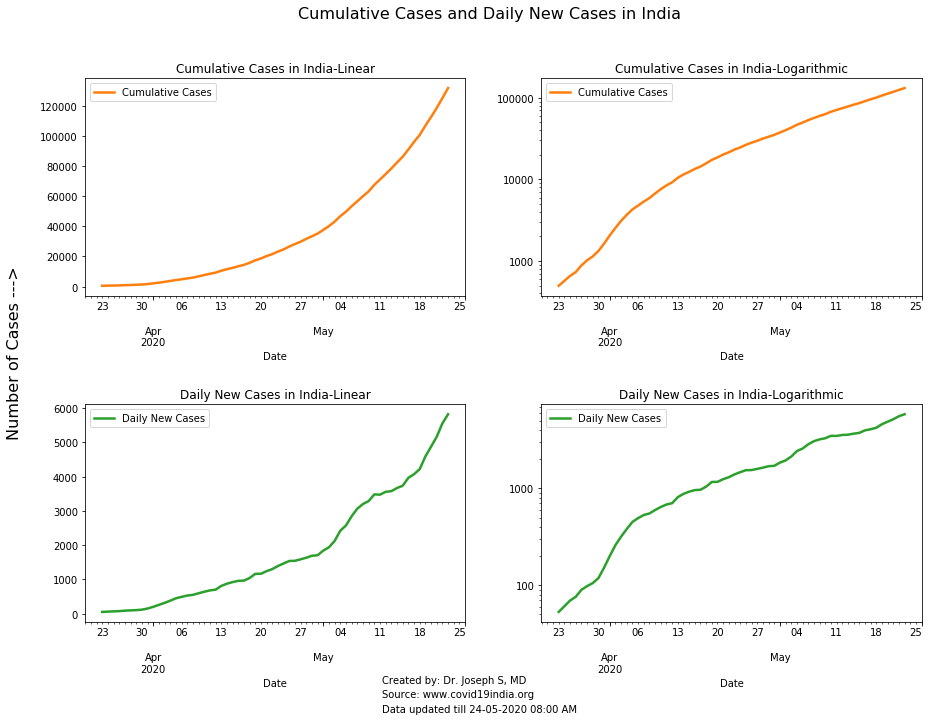

In [107]:
#Sub plots for India
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
figtit="Cumulative Cases and Daily New Cases in India"


ind_cum.tail(y).plot(kind='line', ax=axes[0,0], color='C1', linewidth=lw, title='Cumulative Cases in India-Linear')
ind_cum.tail(y).plot(kind='line', ax=axes[0,1], color='C1', linewidth=lw, title='Cumulative Cases in India-Logarithmic').set_yscale('log')
axes[0,1].yaxis.set_major_formatter(formatter)
ind_daily_7dra.tail(y).plot(kind='line', ax=axes[1,0], color='C2', linewidth=lw, title='Daily New Cases in India-Linear')
ind_daily_7dra.tail(y).plot(kind='line', ax=axes[1,1], color='C2', linewidth=lw, title='Daily New Cases in India-Logarithmic').set_yscale('log')
axes[1,1].yaxis.set_major_formatter(formatter)
fig.suptitle(figtit, fontsize=16)

footer1()

fig.text(0.06, 0.5, ytitle, ha='center', va='center', rotation='vertical', fontsize=16)


figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

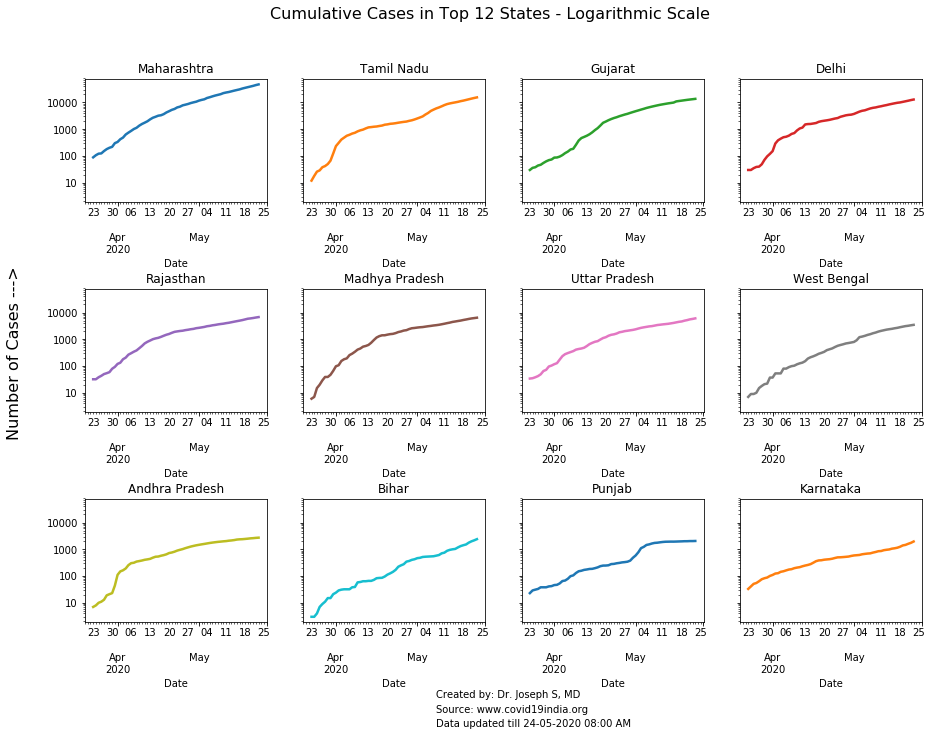

In [108]:
#Subplots for Top 12 States Cumulative
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey='all')
plt.subplots_adjust(hspace=0.7)
figtit="Cumulative Cases in Top 12 States - Logarithmic Scale"

try:
    for i in range(3):
        for j in range(4):
            a=(i*4)+j
            b=a%10
            c="C"+str(b)
            top12cum[top12cum.columns[a]].tail(y).plot(kind='line', ax=axes[i,j], color=c, linewidth=lw, title=top12cum.columns[a]).set_yscale('log')
            axes[i,j].yaxis.set_major_formatter(formatter)
except: 
    print('Done')
fig.suptitle(figtit, fontsize=16)
footer2()

fig.text(0.06, 0.5, ytitle, ha='center', va='center', rotation='vertical', fontsize=16)

figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

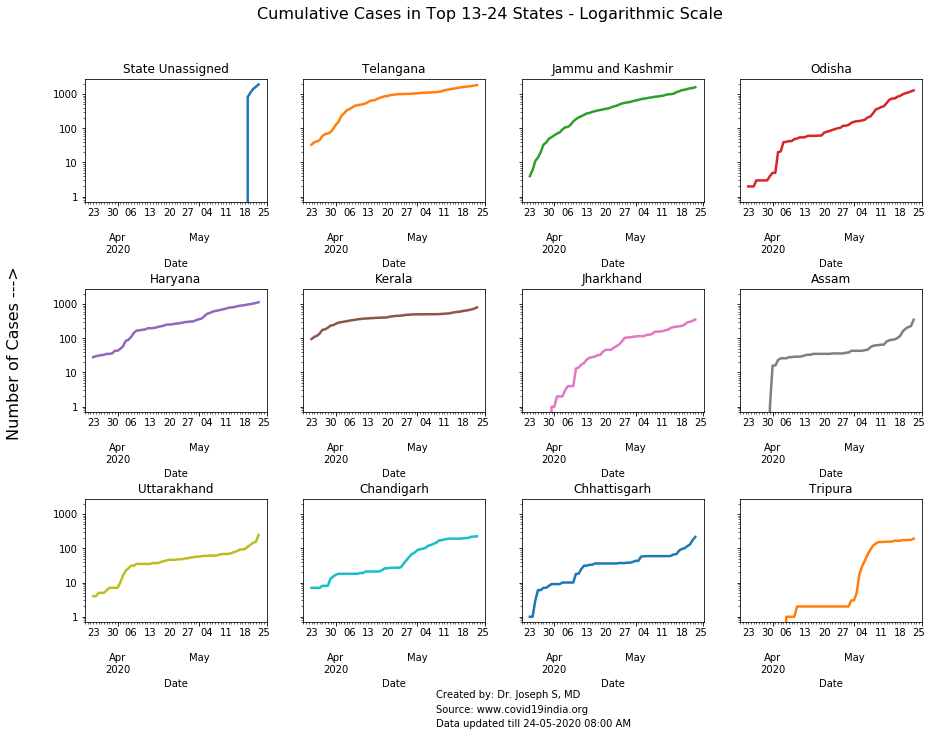

In [109]:
#Sub plots for top 13-24 States Cumulative
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.7)
figtit="Cumulative Cases in Top 13-24 States - Logarithmic Scale"

try:
    for i in range(3):
        for j in range(4):
            a=(i*4)+j
            b=a%10
            c="C"+str(b)
            second12cum[second12cum.columns[a]].tail(y).plot(kind='line', ax=axes[i,j],color=c, linewidth=lw, title=second12cum.columns[a]).set_yscale('log')
            axes[i,j].yaxis.set_major_formatter(formatter)
except: 
    print('Done')
fig.suptitle(figtit, fontsize=16)
footer2()
fig.text(0.06, 0.5, ytitle, ha='center', va='center', rotation='vertical', fontsize=16)

figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

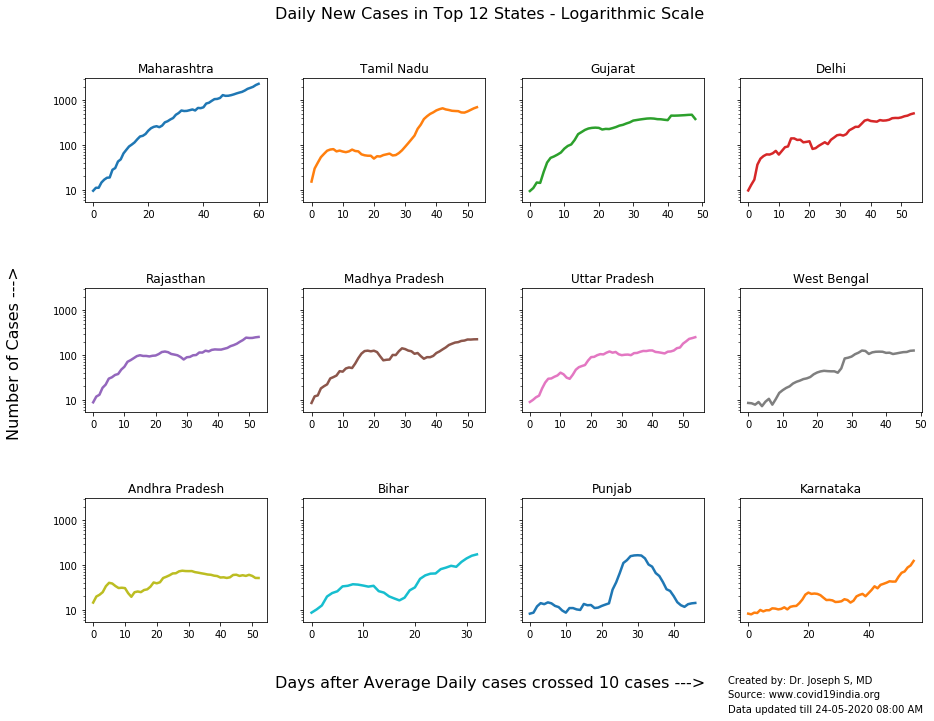

In [110]:
#Subplots for Daily New Cases - Top 12 States

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.7)
figtit="Daily New Cases in Top 12 States - Logarithmic Scale"

try:
    for i in range(3):
        for j in range(4):
            a=(i*4)+j
            b=a%10
            c="C"+str(b)
            top12new7dra_dat2[top12new7dra_dat2.columns[a]].plot(kind='line', ax=axes[i,j], color=c, linewidth=lw, title=top12new7dra_dat2.columns[a]).set_yscale('log')
            axes[i,j].yaxis.set_major_formatter(formatter)
except: 
    print('Done')
fig.suptitle(figtit, fontsize=16)
footer3()
fig.text(0.5, 0.04, dat, ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, ytitle, ha='center', va='center', rotation='vertical', fontsize=16)

figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()

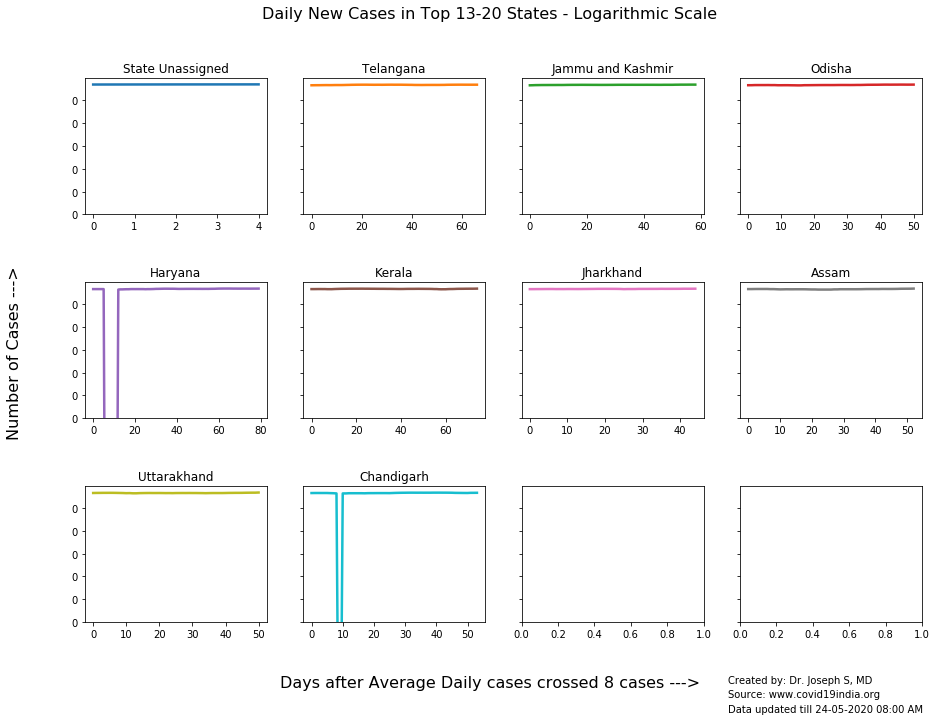

In [111]:
#Subplots for Daily New Cases - Top 13-24 States
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), sharex=False, sharey=True)
plt.subplots_adjust(hspace=0.5)
figtit="Daily New Cases in Top 13-20 States - Logarithmic Scale"

try:
    for i in range(3):
        for j in range(4):
            a=(i*4)+j
            b=a%10
            c="C"+str(b)
            if a<10:
                second12new7dra_dat2[second12new7dra_dat2.columns[a]].plot(kind='line', ax=axes[i,j], color=c, linewidth=lw, title=second12new7dra_dat2.columns[a]).set_yscale('log')
                axes[i,j].yaxis.set_major_formatter(formatter)
            
except: 
    print('Done')
fig.suptitle(figtit, fontsize=16)
footer3()
fig.text(0.5, 0.04, dae, ha='center', va='center', fontsize=16)
fig.text(0.06, 0.5, ytitle, ha='center', va='center', rotation='vertical', fontsize=16)

figtit=figtit+".jpg"
figpath=export_path/figtit
plt.savefig(figpath, dpi=300, bbox_inches='tight')
fig.show()